In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-04-02 00:44:53.048426: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
labels = labels.astype(np.float64)

In [6]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually

In [7]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [8]:
import json

In [9]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [10]:
X_train = images[0:image_data['84']] 
y_train = labels[0:label_data['84']]
X_val = images[image_data['84']:]
y_val = labels[label_data['84']:]

In [11]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    dropout_change_per_layer=0.0,
    num_layers=4,
    output_activation='sigmoid')

2023-04-02 00:44:55.569866: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-02 00:44:55.780854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-02 00:44:55.783472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:b7:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-02 00:44:55.783490: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-02 00:44:55.786842: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-02 

In [12]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(optimizer = Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [14]:
history = model.fit(X_train, 
                    y_train,
                    batch_size=32, 
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-04-02 00:44:58.305822: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-02 00:44:58.325182: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-04-02 00:44:59.535962: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-02 00:45:00.199232: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-04-02 00:45:00.971447: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-02 00:45:00.971471: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-02 00:45:00.971541: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-02 00:45:01.053938: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-02 00:45:01.885952: I tensorflow/stream_exec

20/20 [==============================] - 56s 2s/step - loss: 0.3396 - iou: 8.1334e-05 - iou_thresholded: 3.3432e-04 - val_loss: 0.0133 - val_iou: 1.3531e-04 - val_iou_thresholded: 3.3159e-04
Epoch 2/200
20/20 [==============================] - 19s 971ms/step - loss: 0.0064 - iou: 2.7095e-04 - iou_thresholded: 3.7044e-04 - val_loss: 0.0065 - val_iou: 5.5776e-04 - val_iou_thresholded: 3.3159e-04
Epoch 3/200
20/20 [==============================] - 19s 973ms/step - loss: 0.0046 - iou: 4.0939e-04 - iou_thresholded: 3.0229e-04 - val_loss: 0.0066 - val_iou: 9.0621e-04 - val_iou_thresholded: 3.3159e-04
Epoch 4/200
20/20 [==============================] - 19s 974ms/step - loss: 0.0041 - iou: 6.5580e-04 - iou_thresholded: 3.1648e-04 - val_loss: 0.0057 - val_iou: 0.0015 - val_iou_thresholded: 3.3159e-04
Epoch 5/200
20/20 [==============================] - 19s 970ms/step - loss: 0.0037 - iou: 0.0012 - iou_thresholded: 3.1556e-04 - val_loss: 0.0049 - val_iou: 0.0023 - val_iou_thresholded: 3.3159e-

20/20 [==============================] - 19s 970ms/step - loss: 0.0029 - iou: 0.0036 - iou_thresholded: 3.1359e-04 - val_loss: 0.0040 - val_iou: 0.0048 - val_iou_thresholded: 3.3159e-04
Epoch 43/200
20/20 [==============================] - 19s 971ms/step - loss: 0.0029 - iou: 0.0043 - iou_thresholded: 3.0439e-04 - val_loss: 0.0038 - val_iou: 0.0080 - val_iou_thresholded: 3.3159e-04
Epoch 44/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0027 - iou: 0.0061 - iou_thresholded: 3.1015e-04 - val_loss: 0.0036 - val_iou: 0.0102 - val_iou_thresholded: 3.3159e-04
Epoch 45/200
20/20 [==============================] - 19s 973ms/step - loss: 0.0026 - iou: 0.0085 - iou_thresholded: 3.1777e-04 - val_loss: 0.0035 - val_iou: 0.0149 - val_iou_thresholded: 3.3159e-04
Epoch 46/200
20/20 [==============================] - 19s 968ms/step - loss: 0.0025 - iou: 0.0128 - iou_thresholded: 3.2223e-04 - val_loss: 0.0037 - val_iou: 0.0175 - val_iou_thresholded: 3.3159e-04
Epoch 47/200
20/20

20/20 [==============================] - 19s 971ms/step - loss: 0.0022 - iou: 0.0194 - iou_thresholded: 3.3745e-04 - val_loss: 0.0029 - val_iou: 0.0337 - val_iou_thresholded: 3.3159e-04
Epoch 85/200
20/20 [==============================] - 19s 971ms/step - loss: 0.0021 - iou: 0.0249 - iou_thresholded: 3.2770e-04 - val_loss: 0.0027 - val_iou: 0.0383 - val_iou_thresholded: 3.3159e-04
Epoch 86/200
20/20 [==============================] - 19s 969ms/step - loss: 0.0020 - iou: 0.0311 - iou_thresholded: 3.1009e-04 - val_loss: 0.0024 - val_iou: 0.0584 - val_iou_thresholded: 3.3159e-04
Epoch 87/200
20/20 [==============================] - 19s 970ms/step - loss: 0.0019 - iou: 0.0587 - iou_thresholded: 0.0097 - val_loss: 0.0028 - val_iou: 0.0714 - val_iou_thresholded: 3.3073e-04
Epoch 88/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0020 - iou: 0.0607 - iou_thresholded: 0.0272 - val_loss: 0.0025 - val_iou: 0.0902 - val_iou_thresholded: 0.0462
Epoch 89/200
20/20 [==========

Epoch 126/200
20/20 [==============================] - 19s 970ms/step - loss: 0.0051 - iou: 3.8363e-04 - iou_thresholded: 3.0119e-04 - val_loss: 0.0057 - val_iou: 5.1207e-04 - val_iou_thresholded: 3.3159e-04
Epoch 127/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0052 - iou: 5.0979e-04 - iou_thresholded: 3.2467e-04 - val_loss: 0.0054 - val_iou: 7.6379e-04 - val_iou_thresholded: 3.3159e-04
Epoch 128/200
20/20 [==============================] - 19s 972ms/step - loss: 0.0037 - iou: 7.5296e-04 - iou_thresholded: 3.3683e-04 - val_loss: 0.0055 - val_iou: 6.0254e-04 - val_iou_thresholded: 3.3159e-04
Epoch 129/200
20/20 [==============================] - 19s 967ms/step - loss: 0.0035 - iou: 0.0011 - iou_thresholded: 3.3683e-04 - val_loss: 0.0051 - val_iou: 9.3202e-04 - val_iou_thresholded: 3.3159e-04
Epoch 130/200
20/20 [==============================] - 19s 968ms/step - loss: 0.0032 - iou: 0.0016 - iou_thresholded: 3.2181e-04 - val_loss: 0.0045 - val_iou: 0.0020 - val_

20/20 [==============================] - 19s 974ms/step - loss: 0.0021 - iou: 0.0476 - iou_thresholded: 0.0466 - val_loss: 0.0032 - val_iou: 0.0569 - val_iou_thresholded: 0.0392
Epoch 168/200
20/20 [==============================] - 19s 969ms/step - loss: 0.0020 - iou: 0.0557 - iou_thresholded: 0.0575 - val_loss: 0.0034 - val_iou: 0.0246 - val_iou_thresholded: 4.6929e-04
Epoch 169/200
20/20 [==============================] - 19s 971ms/step - loss: 0.0021 - iou: 0.0433 - iou_thresholded: 0.0396 - val_loss: 0.0032 - val_iou: 0.0435 - val_iou_thresholded: 0.0145
Epoch 170/200
20/20 [==============================] - 19s 973ms/step - loss: 0.0020 - iou: 0.0558 - iou_thresholded: 0.0563 - val_loss: 0.0029 - val_iou: 0.0600 - val_iou_thresholded: 0.0610
Epoch 171/200
20/20 [==============================] - 19s 966ms/step - loss: 0.0021 - iou: 0.0577 - iou_thresholded: 0.0659 - val_loss: 0.0031 - val_iou: 0.0473 - val_iou_thresholded: 0.0241
Epoch 172/200
20/20 [=============================

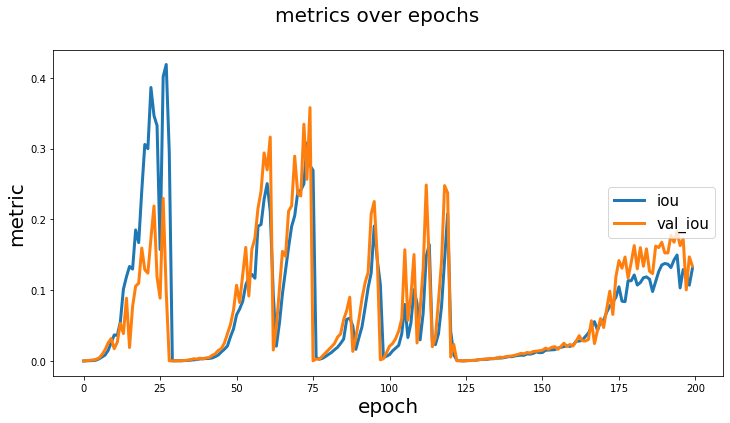

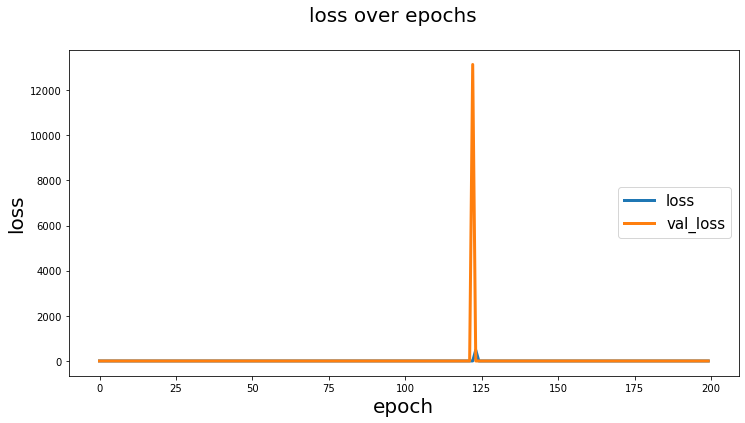

In [15]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [16]:
y_pred = model.predict(X_val)

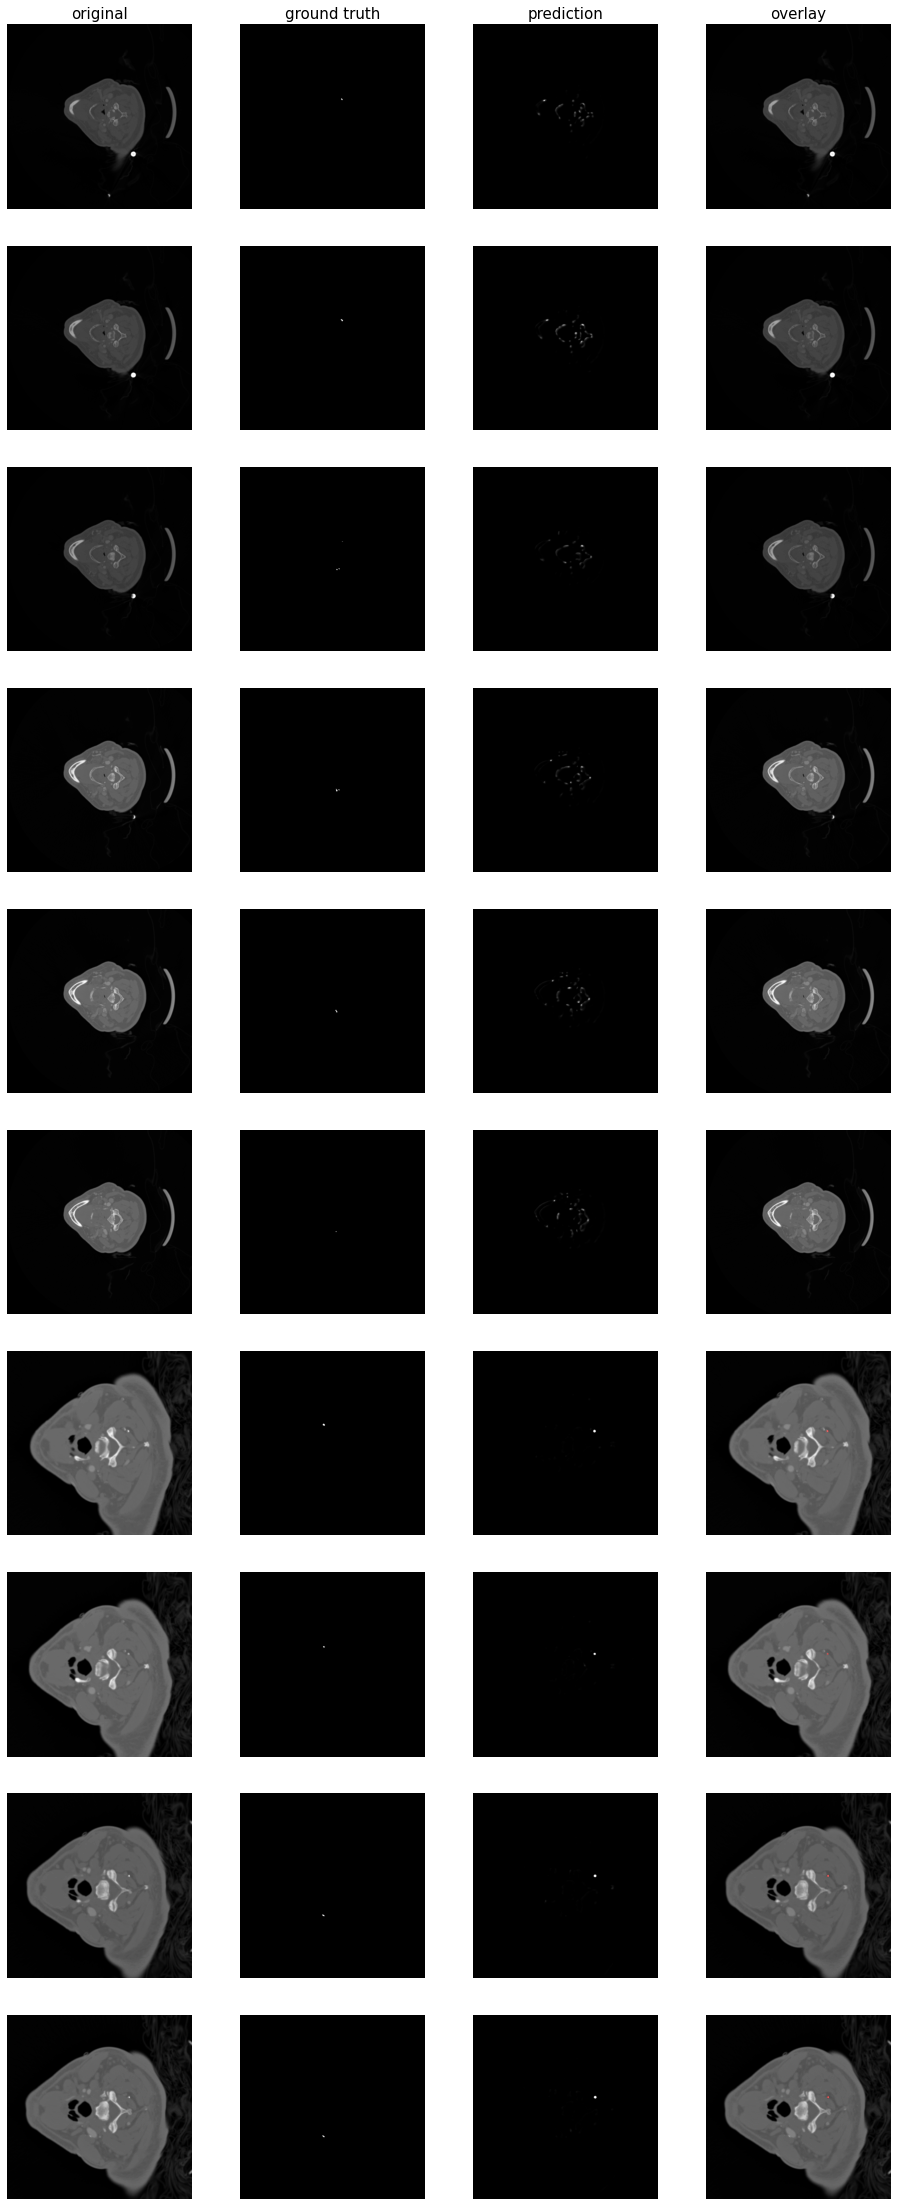

In [17]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [18]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

5/5 [==============================] - 1s 194ms/step - loss: 0.0030 - iou: 0.1342 - iou_thresholded: 0.1630
